In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import DataLoader

In [3]:
drivers = [
    'GeesungOh',
    'EuiseokJeong',
    # 'TaesanKim',
]

states = [
    # 'Unknown',
    'Angry/Disgusting',
    # 'Excited/Surprised',
    'Sad/Fatigued',
    # 'Happy/Neutral',
]

input_setup = {
    'cols_CAN':['LAT_ACCEL', 'LONG_ACCEL','YAW_RATE', 'SAS_Angle',],
    'deltaT_CAN':[-5, 0],      # sec
    'sampling_time_CAN':0.5,    # sec
    
    'cols_BIO':['EDA'],
    'deltaT_BIO':[-5, 0],      # sec
    'sampling_time_BIO':0.5,     # sec
    
    'image_view':['front'],
    'image_mode':['ir'],
    'deltaT_image':[-4, -2],      # sec
    'sampling_time_image':1,    # hz
}

data_loader = DataLoader(drivers=drivers,
                         states=states,
                         batch_size=32,
                         shuffle=True,
                         name='demo_training',
                         kwargs=input_setup,
                         )

In [4]:
x, y = data_loader[2]
x_can, x_bio, x_imgs = x

print(x_can.shape)
print(x_bio.shape)
print(x_imgs['front'].shape)
print(y.shape)

(29, 9, 4)
(29, 9, 1)
(29, 1, 720, 1280, 3)
(29, 2)


# (Deep learning) Model build

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, LSTM, GlobalAveragePooling2D
import tensorflow as tf

class DemoNet(Model):

    def __init__(self, num_classes=len(states)):
        super(DemoNet, self).__init__()
        
        self.canNbio_l = LSTM(5, activation='tanh')
        self.img_l = Conv2D(3, 5, 1, activation='relu')
        self.GAP = GlobalAveragePooling2D()
        
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, x):
        can_x, bio_x, img_x = x
        
        input_canNbio = tf.concat([can_x, bio_x], axis=-1)  # (None, 9, 5)
        out_canNbio = self.canNbio_l(input_canNbio) # (None, 5)
        
        input_img = tf.squeeze(img_x['front'], axis=1)  # (None, 720, 1280, 3)
        out_conv = self.img_l(input_img)    # (None, 716, 1276, 3)
        out_gap = self.GAP(out_conv)    # (None, 3)
        
        concat = tf.concat([out_canNbio, out_gap], axis=-1) # (None, 8)
        
        output_ = self.classifier(concat)
        
        return output_  # (None, 2)
        
        

In [5]:
demo_model = DemoNet()
pred_y = demo_model(x)
print(pred_y.shape)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



NameError: name 'x' is not defined

In [6]:
demo_model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [7]:
results = demo_model.fit(data_loader,
                        epochs=5,)

Epoch 1/5


2023-05-10 01:13:53.232231: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 33s 7s/step - loss: 1.3361 - categorical_accuracy: 0.1600
Epoch 2/5
4/4 [==============================] - 32s 8s/step - loss: 1.0953 - categorical_accuracy: 0.1600
Epoch 3/5
4/4 [==============================] - 33s 8s/step - loss: 0.9151 - categorical_accuracy: 0.1600
Epoch 4/5
4/4 [==============================] - 34s 8s/step - loss: 0.7529 - categorical_accuracy: 0.2900
Epoch 5/5
4/4 [==============================] - 33s 8s/step - loss: 0.6482 - categorical_accuracy: 0.7300


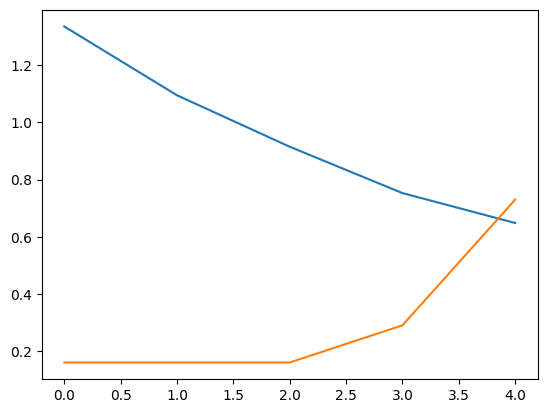

In [9]:
import matplotlib.pyplot as plt

plt.plot(results.history['loss'], label='Loss')
plt.plot(results.history['categorical_accuracy'], label='Accuracy')
